# Diverse Tools for Acclerating Numerical Computations: Blosc2 DSL and Numba

This notebook explores the use of the Blosc2 DSL (Domain Specific Language) functionality and Numba, two compiler-based approaches to accelerate numerical calculations. For certain cases, a DSL kernel is all that is necessary; however, one may also use Blosc2+Numba with certain key functions implemented in DSL to accelerate parts of the workflow. We will look at both these cases (pure DSL kernel, mix-and-match DSL kernel and Numba) below.
- Example 1: Black-Scholes formula evaluation. In this case, one may do everything with DSL kernels, and we compare performance to that of Numba as a direct competitor.
- Example 2: 1D histogramming. In this case, not all steps in the computation are supported for DSL kernels. However, we show how simple it is to slough off the trickier calculations to Numba, and preserve gains for other function calls which can use a DSL kernel. In this way, one still sees speedups compared to a pure Numba approach.

These examples have been taken from the Numba project page: 

To analyse the results, we will generate some profiling statistics. Here is a quick guide to their interpretation:
- **First run** includes one-time costs (JIT/compilation, loader, setup).
- **Best run** represents steady-state compute throughput after warmup.
- For DSL backends, cache state affects first-run results (`cc` and `tcc` can hit warm caches).

In [1]:
import time

import matplotlib.pyplot as plt
import numba
import numpy as np

import blosc2


## Profiling Functions
def best_time(func, repeats=3, warmup=1):
    for _ in range(warmup):
        func()
    best = float("inf")
    best_out = None
    for _ in range(repeats):
        t0 = time.perf_counter()
        out = func()
        dt = time.perf_counter() - t0
        if dt < best:
            best = dt
            best_out = out
    return best, best_out


def profile(run_numpy_baseline, run_numba_native, run_dsl_cc, run_dsl_tcc, title):
    print("First iteration timings (one-time overhead included):")
    t0 = time.perf_counter()
    _ = run_numpy_baseline()
    t_numpy_baseline = time.perf_counter() - t0
    print(f"Numpy baseline: {t_numpy_baseline:.6f} s")

    # Measure first iteration (includes one-time overhead, especially JIT compile)
    t0 = time.perf_counter()
    _ = run_numba_native()
    t_numba_native_first = time.perf_counter() - t0
    print(f"Native numba first run: {t_numba_native_first:.6f} s")

    t0 = time.perf_counter()
    _ = run_dsl_cc()
    t_dsl_cc_first = time.perf_counter() - t0
    print(f"Blosc2+DSL(cc) first run:          {t_dsl_cc_first:.6f} s")

    t0 = time.perf_counter()
    _ = run_dsl_tcc()
    t_dsl_tcc_first = time.perf_counter() - t0
    print(f"Blosc2+DSL(tcc) first run:         {t_dsl_tcc_first:.6f} s")

    t_numba_native, res_numba_native = best_time(run_numba_native, repeats=5, warmup=1)
    t_dsl_cc, res_dsl_cc = best_time(run_dsl_cc, repeats=3, warmup=1)
    t_dsl_tcc, res_dsl_tcc = best_time(run_dsl_tcc, repeats=3, warmup=1)

    cold_overhead_native = t_numba_native_first - t_numba_native
    cold_overhead_dsl_tcc = t_dsl_tcc_first - t_dsl_tcc
    cold_overhead_dsl_cc = t_dsl_cc_first - t_dsl_cc

    steady_speedup_dsl_tcc_vs_native = t_numba_native / t_dsl_tcc
    steady_speedup_dsl_cc_vs_native = t_numba_native / t_dsl_cc

    def _max_abs_diff(a, b):
        return np.max(np.abs(np.asarray(a) - np.asarray(b))).item()

    if isinstance(res_numba_native, tuple):
        c_max = _max_abs_diff(res_numba_native[0], res_dsl_cc[0])
        d_max = _max_abs_diff(res_dsl_cc[0], res_dsl_tcc[0])
    else:
        c_max = _max_abs_diff(res_numba_native, res_dsl_cc)
        d_max = _max_abs_diff(res_dsl_cc, res_dsl_tcc)

    print("\nBest-time stats:")
    print(f"Native numba time (best): {t_numba_native:.6f} s")
    print(f"Blosc2+DSL(cc) time (best):  {t_dsl_cc:.6f} s")
    print(f"Blosc2+DSL(tcc) time (best): {t_dsl_tcc:.6f} s")
    print(f"Blosc2+DSL(cc) / native:    {t_dsl_cc / t_numba_native:.2f}x")
    print(f"Blosc2+DSL(tcc) / native:   {t_dsl_tcc / t_numba_native:.2f}x")
    print(f"Blosc2+DSL(tcc) / Blosc2+DSL(cc): {t_dsl_tcc / t_dsl_cc:.2f}x")
    print("\nCold-start overhead (first - best):")
    print(f"Native numba overhead:        {cold_overhead_native:.6f} s")
    print(f"Blosc2+DSL(tcc) overhead:     {cold_overhead_dsl_tcc:.6f} s")
    print(f"Blosc2+DSL(cc) overhead:      {cold_overhead_dsl_cc:.6f} s")

    print("\nSteady-state speedup vs native (best):")
    print(f"Blosc2+DSL(tcc) speedup vs native:{steady_speedup_dsl_tcc_vs_native:.2f}x")
    print(f"Blosc2+DSL(cc) speedup vs native: {steady_speedup_dsl_cc_vs_native:.2f}x")
    print(f"max |native-dsl(cc)|:       {c_max:.6f}")
    print(f"max |dsl(cc)-dsl(tcc)|:     {d_max:.6f}")

    labels = ["Numpy baseline", "Native Numba", "Blosc2+DSL (tcc)", "Blosc2+DSL (cc)"]
    first_times = [t_numba_native_first, t_dsl_tcc_first, t_dsl_cc_first]
    best_times = [t_numba_native, t_dsl_tcc, t_dsl_cc]

    x = 1 + np.arange(len(best_times))
    width = 0.36

    fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
    ax.bar([0], [t_numpy_baseline], width, label="Numpy", color="r")

    ax.bar(x - width / 2, first_times, width, label="First run", color="#4C78A8")
    ax.bar(x + width / 2, best_times, width, label="Best run", color="#F58518")

    x = np.arange(len(labels))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Time (seconds)")
    ax.set_title(f"{title}: Native Numba vs Blosc2 DSL Backends")
    ax.legend()

    ax.text(0, t_numpy_baseline, f"{t_numpy_baseline:.3f}s", ha="center", va="bottom")
    for i, t in enumerate(first_times):
        ax.text(1 + i - width / 2, t, f"{t:.3f}s", ha="center", va="bottom")
    for i, t in enumerate(best_times):
        ax.text(1 + i + width / 2, t, f"{t:.3f}s", ha="center", va="bottom")

    plt.show()

    return res_numba_native, res_dsl_cc, res_dsl_tcc

### Example 1: Black-Scholes formula evaluation

In quantitative finance, the Black-Scholes model is famous as one of the first successful applications of mathematical techniques to the pricing of financial instruments, specifically options. For simplicity we consider only European options. A call (put) option is a contract, whose holder has the right, but not the obligation, to purchase (sell) an underlying asset at a set price (the strike price) at a certain future time (the exercise time $T$). For a fixed strike price $X$, the option's value $C(S, t)$ thus depends on both the market price of the underlying $S$, as well as time $t$ (since one moves closer to exercise time). One might want to incorporate additional parameters such as the volatility $\sigma$ of the underlying price. Finally, since one typically may generate returns on money with zero risk, (e.g. by buying government bonds), the price of the option must be adjusted by the risk-free rate $r$ to reflect its true value.

Assuming the price of the underlying asset follows a geometric brownian motion $dS = \mu S dt + \sigma S dW_t$, one may derive the Black-Scholes equation
$$\partial_t C + rS\partial_S C + \frac{1}{2}\sigma^2 S^2 \partial_{SS} C = rC,$$
with boundary conditions $C(0, t) = 0, \forall t$, $C(S, T) = \max\{S - X, 0\}$ (since at exercise time, one may exercise the option, buying the asset at $X$ and selling at $S$, or not). This may be transformed into a diffusion equation, with solution

$$C(S,t) = (S\phi(d_+) - Xe^{-rT} \phi(d_-)),$$ 

where $\phi$ is the standard normal cumulative distribution function and 
$$d_+ = \frac{\log(S / X) + t(r + \sigma^2/2)}{\sigma\sqrt{t}}, \quad d_- = d_+ - \sigma\sqrt{t}.$$

This is an excellent test case for compiled libraries since a) all operations are elementwise and so easy to handle and b) many transcendental functions are used, which can be readily accelerated by good compiling practices. So let's dive in and compare Numba and Blosc2-DSL!

#### Setup

In [2]:
# Setup
N = int(1e8)
S = np.linspace(0.01, 1.2, N)  # price of underlying
T = np.linspace(0.01, 2, N)  # time to exercise
X = 1.0  # strike price
sigma = 1.0  # volatility
risk_rate = 0.1  # risk-free rate

# Keep compression overhead low for the timing comparison
cparams_fast = blosc2.CParams(codec=blosc2.Codec.LZ4, clevel=1)
S_b2 = blosc2.asarray(S, cparams=cparams_fast)
T_b2 = blosc2.asarray(T, cparams=cparams_fast)

Numpy Baseline

In [3]:
def cnd_np(d):
    A1 = 0.31938153
    A2 = -0.356563782
    A3 = 1.781477937
    A4 = -1.821255978
    A5 = 1.330274429
    RSQRT2PI = 0.39894228040143267793994605993438
    K = 1.0 / (1.0 + 0.2316419 * np.fabs(d))
    ret_val = RSQRT2PI * np.exp(-0.5 * d * d) * (K * (A1 + K * (A2 + K * (A3 + K * (A4 + K * A5)))))
    return np.where(d > 0, 1.0 - ret_val, ret_val)


def black_scholes_np(stockPrice, optionStrike, optionYears, Riskfree, Volatility):
    S = stockPrice
    X = optionStrike
    T = optionYears
    R = Riskfree
    V = Volatility
    sqrtT = np.sqrt(T)
    d1 = (np.log(S / X) + (R + 0.5 * V * V) * T) / (V * sqrtT)
    d2 = d1 - V * sqrtT
    cndd1 = cnd_np(d1)
    cndd2 = cnd_np(d2)

    expRT = np.exp((-1.0 * R) * T)
    return S * cndd1 - X * expRT * cndd2

Numba functions

In [4]:
import math


@numba.njit(fastmath=False)
def cnd_numba(d):
    A1 = 0.31938153
    A2 = -0.356563782
    A3 = 1.781477937
    A4 = -1.821255978
    A5 = 1.330274429
    RSQRT2PI = 0.39894228040143267793994605993438
    K = 1.0 / (1.0 + 0.2316419 * math.fabs(d))
    ret_val = RSQRT2PI * math.exp(-0.5 * d * d) * (K * (A1 + K * (A2 + K * (A3 + K * (A4 + K * A5)))))
    if d > 0:
        ret_val = 1.0 - ret_val
    return ret_val


@numba.njit(parallel=True, fastmath=False)
def black_scholes_numba(stockPrice, optionStrike, optionYears, Riskfree, Volatility):
    callResult = np.empty_like(stockPrice)

    S = stockPrice
    X = optionStrike
    T = optionYears
    R = Riskfree
    V = Volatility
    for i in numba.prange(len(S)):
        sqrtT = math.sqrt(T[i])
        d1 = (math.log(S[i] / X) + (R + 0.5 * V * V) * T[i]) / (V * sqrtT)
        d2 = d1 - V * sqrtT
        cndd1 = cnd_numba(d1)
        cndd2 = cnd_numba(d2)

        expRT = math.exp((-1.0 * R) * T[i])
        callResult[i] = S[i] * cndd1 - X * expRT * cndd2

    return callResult

Blosc2-DSL functions

In [5]:
@blosc2.dsl_kernel
def black_scholes_dsl(S, X, T, R, V):
    A1 = 0.31938153
    A2 = -0.356563782
    A3 = 1.781477937
    A4 = -1.821255978
    A5 = 1.330274429
    RSQRT2PI = 0.39894228040143267793994605993438

    sqrtT = sqrt(T)  # noqa : F821
    d1 = (log(S / X) + (R + 0.5 * V * V) * T) / (V * sqrtT)  # noqa : F821
    d2 = d1 - V * sqrtT
    K = 1.0 / (1.0 + 0.2316419 * abs(d1))

    ret_val = RSQRT2PI * exp(-0.5 * d1 * d1) * (K * (A1 + K * (A2 + K * (A3 + K * (A4 + K * A5)))))  # noqa : F821
    if d1 > 0:
        cndd1 = 1.0 - ret_val
    else:
        cndd1 = ret_val

    K = 1.0 / (1.0 + 0.2316419 * abs(d2))
    ret_val = RSQRT2PI * exp(-0.5 * d2 * d2) * (K * (A1 + K * (A2 + K * (A3 + K * (A4 + K * A5)))))  # noqa : F821
    if d2 > 0:
        cndd2 = 1.0 - ret_val
    else:
        cndd2 = ret_val

    expRT = exp((-1.0 * R) * T)  # noqa : F821
    # putResult = (X * expRT * (1.0 - cndd2) - S * (1.0 - cndd1))

    return S * cndd1 - X * expRT * cndd2  # callResult


if black_scholes_dsl.dsl_source is None:
    raise RuntimeError("DSL extraction failed. Re-run this cell in a file-backed notebook session.")

print(black_scholes_dsl.dsl_source)

def black_scholes_dsl(S, X, T, R, V):
    A1 = 0.31938153
    A2 = -0.356563782
    A3 = 1.781477937
    A4 = -1.821255978
    A5 = 1.330274429
    RSQRT2PI = 0.39894228040143267793994605993438

    sqrtT = sqrt(T)  # noqa : F821
    d1 = (log(S / X) + (R + 0.5 * V * V) * T) / (V * sqrtT)  # noqa : F821
    d2 = d1 - V * sqrtT
    K = 1.0 / (1.0 + 0.2316419 * abs(d1))

    ret_val = RSQRT2PI * exp(-0.5 * d1 * d1) * (K * (A1 + K * (A2 + K * (A3 + K * (A4 + K * A5)))))  # noqa : F821
    if d1 > 0:
        cndd1 = 1.0 - ret_val
    else:
        cndd1 = ret_val

    K = 1.0 / (1.0 + 0.2316419 * abs(d2))
    ret_val = RSQRT2PI * exp(-0.5 * d2 * d2) * (K * (A1 + K * (A2 + K * (A3 + K * (A4 + K * A5)))))  # noqa : F821
    if d2 > 0:
        cndd2 = 1.0 - ret_val
    else:
        cndd2 = ret_val

    expRT = exp((-1.0 * R) * T)  # noqa : F821
    # putResult = (X * expRT * (1.0 - cndd2) - S * (1.0 - cndd1))

    return S * cndd1 - X * expRT * cndd2  # callResult


#### Profile - Black-Scholes 
Now that we have set up the inputs and the Numba and Blosc2-DSL functions, we can now profile the two approaches and see how they compare.

First iteration timings (one-time overhead included):


Numpy baseline: 4.251876 s
Native numba first run: 0.418843 s
Blosc2+DSL(cc) first run:          0.418602 s
Blosc2+DSL(tcc) first run:         0.411038 s

Best-time stats:
Native numba time (best): 0.138116 s
Blosc2+DSL(cc) time (best):  0.359843 s
Blosc2+DSL(tcc) time (best): 0.409875 s
Blosc2+DSL(cc) / native:    2.61x
Blosc2+DSL(tcc) / native:   2.97x
Blosc2+DSL(tcc) / Blosc2+DSL(cc): 1.14x

Cold-start overhead (first - best):
Native numba overhead:        0.280727 s
Blosc2+DSL(tcc) overhead:     0.001163 s
Blosc2+DSL(cc) overhead:      0.058759 s

Steady-state speedup vs native (best):
Blosc2+DSL(tcc) speedup vs native:0.34x
Blosc2+DSL(cc) speedup vs native: 0.38x
max |native-dsl(cc)|:       0.000000
max |dsl(cc)-dsl(tcc)|:     0.000000


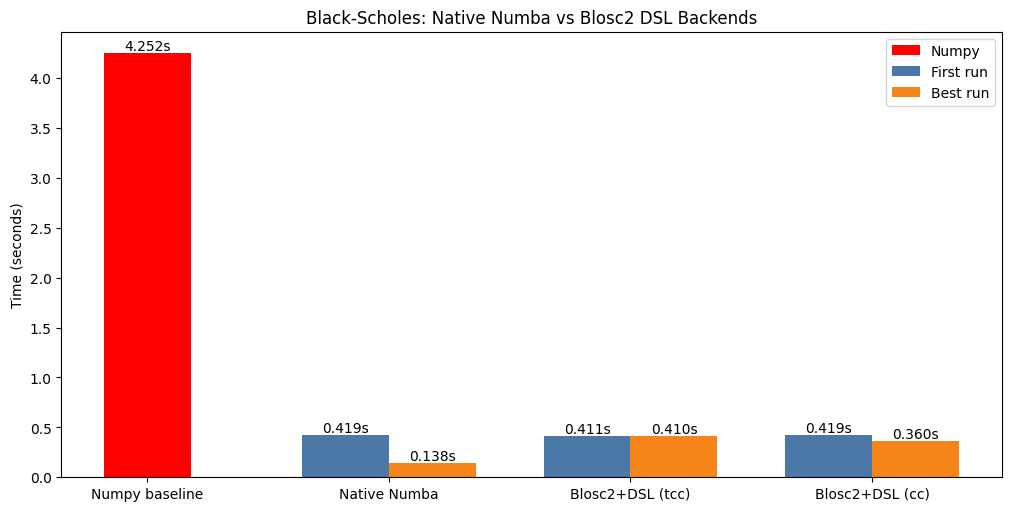

In [6]:
# Profile Black-Scholes
def run_numpy_baseline():
    return black_scholes_np(S, X, T, risk_rate, sigma)


def run_numba_native():
    return black_scholes_numba(S, X, T, risk_rate, sigma)


def run_dsl_cc():
    lazy = blosc2.lazyudf(
        black_scholes_dsl,
        (S_b2, X, T_b2, risk_rate, sigma),
        dtype=np.float64,
        cparams=cparams_fast,
        jit=True,
        jit_backend="cc",
    )
    return lazy.compute()


def run_dsl_tcc():
    lazy = blosc2.lazyudf(
        black_scholes_dsl,
        (S_b2, X, T_b2, risk_rate, sigma),
        dtype=np.float64,
        cparams=cparams_fast,
        jit=True,
        jit_backend="tcc",
    )
    return lazy.compute()


res_numba_native, res_dsl_cc, res_dsl_tcc = profile(
    run_numpy_baseline, run_numba_native, run_dsl_cc, run_dsl_tcc, "Black-Scholes"
)

We see that, once compiled, Numba runs the fastest. This is because it performs many more optimisations than the DSL kernels (compiled either with `tcc` or `cc`); but as a consequence, the first run (which includes the compilation time), can be much slower for Numba in some cases (see below). `tcc` (`tinycc`), which is shipped with the `miniexpr` backend, performs no optimisations and so the compilation takes essentially no time (compared to the computation), and because of its simplicity will work on any platform (including Windows and WebAssembly). `cc` is a mildly more aggressive compiler, which does optimise, and so there is some overhead, but also a consequent performance gain for later runs. Thus `blosc2` offers unparalleled coverage to provide consistent compiled speedups via multithreading for bespoke user-defined functions, with a simple, elementwise pythonic syntax (no indexing required!) - just look at the gains relative to Numpy!

It is also worth noting that Numba is typically extra fast on Intel systems, due to specific design optimisations for the processor architecture. We expect less variation between platforms for Blosc2+DSL kernels.

Now let's plot the results, where one sees the typical upwards curving price as one moves towards the exercise time and/or the price of the underlying increases (here the strike price is 1).

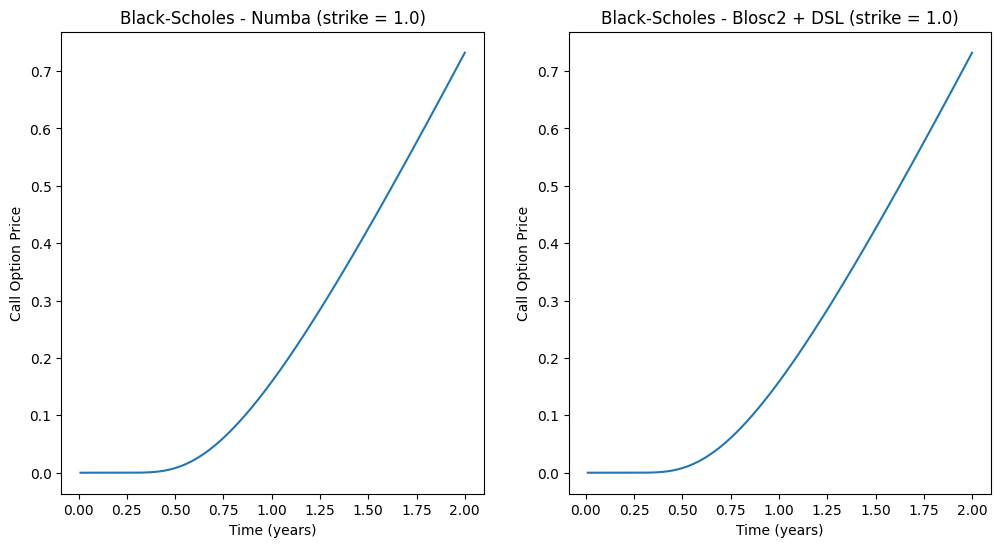

In [7]:
# Plot call price

# Create figure
fig = plt.figure(figsize=(12, 6))

# First 3D subplot
ax1 = fig.add_subplot(1, 2, 1)
surf1 = ax1.plot(T, res_numba_native)
ax1.set_title(f"Black-Scholes - Numba (strike = {X})")
ax1.set_xlabel("Time (years)")
ax1.set_ylabel("Call Option Price")

# Second 3D subplot
ax2 = fig.add_subplot(1, 2, 2)
surf2 = ax2.plot(T, res_dsl_cc)
ax2.set_title(f"Black-Scholes - Blosc2 + DSL (strike = {X})")
ax2.set_xlabel("Time (years)")
ax2.set_ylabel("Call Option Price")

# cbar = fig.colorbar(surf2, ax=[ax1, ax2])
# cbar.set_label("Call option price")
plt.show()

### Example 2: 1D histogramming

One of the most basic data summary techniques is histogramming, which amounts to plotting an empirical distribution of values for some given data. For large datasets, this can become very costly if implemented naively, and so parallel computation and compilation can reap dividends.

We will see this in action by histogramming some sample data from the standard normal distribution. Note that this is not very compressible, and so is perhaps not ideally suited to Blosc2's compression-first paradigm. Nonetheless, Blosc2+DSL does quite well!

In [8]:
# Setup
N = int(1e8)
nbins = 1000
x = np.random.default_rng().normal(0.0, 1.0, size=(N,))

# Keep compression overhead low for the timing comparison
cparams_fast = blosc2.CParams(codec=blosc2.Codec.LZ4, clevel=1)
x_b2 = blosc2.asarray(x, cparams=cparams_fast)

Numba Functions

In [9]:
@numba.jit(parallel=True, nopython=True)
def get_bin_edges(a, bins):
    bin_edges = np.zeros((bins + 1,), dtype=np.float64)
    a_min = a.min()
    a_max = a.max()
    delta = (a_max - a_min) / bins
    for i in numba.prange(bins):
        bin_edges[i] = a_min + i * delta

    bin_edges[-1] = a_max  # Avoid roundoff error on last point
    return bin_edges


@numba.jit(nopython=True)
def compute_bin(x, bin_edges):
    # assuming uniform bins for now
    n = bin_edges.shape[0] - 1
    a_min = bin_edges[0]
    a_max = bin_edges[-1]

    # special case to mirror NumPy behavior for last bin
    if x == a_max:
        return n - 1  # a_max always in last bin

    bin = int(n * (x - a_min) / (a_max - a_min))

    if bin < 0 or bin >= n:
        return None
    else:
        return bin


@numba.jit(nopython=True)
def numba_histogram(a, bins):
    hist = np.zeros((bins,), dtype=np.intp)
    bin_edges = get_bin_edges(a, bins)
    for i in range(len(a)):
        x = a[i]
        bin = compute_bin(x, bin_edges)
        if bin is not None:
            hist[int(bin)] += 1

    return hist, bin_edges

##### Blosc2 DSL + Numba Functions

Because the DSL engine only works with elementwise operations (so that the output has the same shape as the inputs), the final histogramming step (which sorts e.g. $10^9$ elements into an output of $100$ bins) cannot be performed with a DSL kernel. Nonetheless, we can use DSL kernels for the other steps, and fold in a standard numba-compiled function using the ``lazyudf`` constructor.

In [10]:
@blosc2.dsl_kernel
def dsl_bin_edges(bin_edges, bin_max, delta):
    if _i0 == _n0 - 1:  # noqa : F821
        return bin_max  # Avoid roundoff error on last point
    else:
        return bin_edges + _i0 * delta  # noqa : F821


@blosc2.dsl_kernel
def dsl_computebin(x, nbins, bin_max, bin_min):
    # special case to mirror NumPy behavior for last bin
    if x == bin_max:
        return nbins - 1  # a_max always in last bin

    bin = int(nbins * (x - bin_min) / (bin_max - bin_min))

    if bin < 0 or bin >= nbins:
        bin = -1
    return bin


@numba.jit(nopython=True)
def numba_bin2hist(inputs_tuple, hist, offset):
    bin_list = inputs_tuple[0]
    for i in range(len(bin_list)):
        b = bin_list[i]
        if b != -1:
            hist[b] += 1


def dsl_histogram(a, bins, jit_backend="cc"):
    # use miniexpr on blosc2_array
    bin_min = a.min()
    bin_max = a.max()
    delta = (bin_max - bin_min) / bins
    bin_edges = blosc2.full((bins + 1,), fill_value=bin_min)
    lazy_binedges = blosc2.lazyudf(
        dsl_bin_edges,
        (bin_edges, bin_max, delta),
        dtype=np.float32,
        cparams=cparams_fast,
        jit_backend=jit_backend,
    )
    bin_edges = lazy_binedges.compute()
    lazy_computebin = blosc2.lazyudf(
        dsl_computebin,
        (a, nbins, bin_max, bin_min),
        dtype=np.int32,
        cparams=cparams_fast,
        jit_backend=jit_backend,
    )
    bin_list = lazy_computebin.compute()
    hist = np.zeros((bins,), dtype=np.int32)
    lazy_bin2hist = blosc2.lazyudf(
        numba_bin2hist, (bin_list,), dtype=np.int32, cparams=cparams_fast, in_place=True
    )
    lazy_bin2hist.compute(out=hist)

    return hist, bin_edges


if dsl_bin_edges.dsl_source is None:
    raise RuntimeError("DSL extraction failed. Re-run this cell in a file-backed notebook session.")

print(dsl_bin_edges.dsl_source)

if dsl_computebin.dsl_source is None:
    raise RuntimeError("DSL extraction failed. Re-run this cell in a file-backed notebook session.")

print(dsl_computebin.dsl_source)

def dsl_bin_edges(bin_edges, bin_max, delta):
    if _i0 == _n0 - 1:  # noqa : F821
        return bin_max  # Avoid roundoff error on last point
    else:
        return bin_edges + _i0 * delta  # noqa : F821
def dsl_computebin(x, nbins, bin_max, bin_min):
    # special case to mirror NumPy behavior for last bin
    if x == bin_max:
        return nbins - 1  # a_max always in last bin

    bin = int(nbins * (x - bin_min) / (bin_max - bin_min))

    if bin < 0 or bin >= nbins:
        bin = -1
    return bin


Run profiling and check results

First iteration timings (one-time overhead included):
Numpy baseline: 0.429584 s
Native numba first run: 0.943224 s
Blosc2+DSL(cc) first run:          0.281095 s
Blosc2+DSL(tcc) first run:         0.207404 s

Best-time stats:
Native numba time (best): 0.142775 s
Blosc2+DSL(cc) time (best):  0.199214 s
Blosc2+DSL(tcc) time (best): 0.207507 s
Blosc2+DSL(cc) / native:    1.40x
Blosc2+DSL(tcc) / native:   1.45x
Blosc2+DSL(tcc) / Blosc2+DSL(cc): 1.04x

Cold-start overhead (first - best):
Native numba overhead:        0.800449 s
Blosc2+DSL(tcc) overhead:     -0.000102 s
Blosc2+DSL(cc) overhead:      0.081881 s

Steady-state speedup vs native (best):
Blosc2+DSL(tcc) speedup vs native:0.69x
Blosc2+DSL(cc) speedup vs native: 0.72x
max |native-dsl(cc)|:       0.000000
max |dsl(cc)-dsl(tcc)|:     0.000000


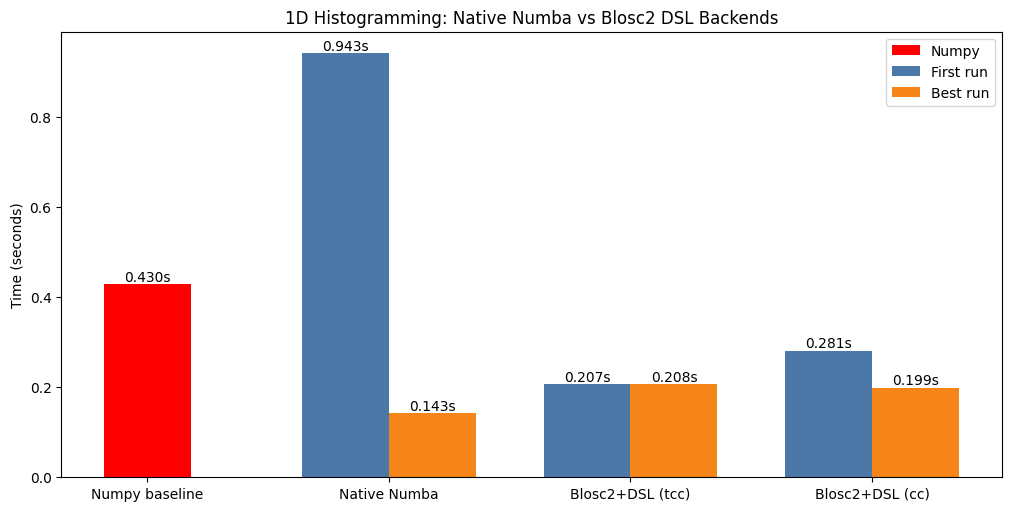

In [11]:
# Profile histogram
def run_numpy_baseline():
    return np.histogram(x, nbins)


def run_numba_native():
    return numba_histogram(x, nbins)


def run_dsl_cc():
    return dsl_histogram(x_b2, nbins, "cc")


def run_dsl_tcc():
    return dsl_histogram(x_b2, nbins, "tcc")


res_numba_native, res_dsl_cc, res_dsl_tcc = profile(
    run_numpy_baseline, run_numba_native, run_dsl_cc, run_dsl_tcc, "1D Histogramming"
)

As mentioned above, Numba's aggressive compile-time optimisations can make it very slow on the first run - even slower than Numpy. On the other hand, the `tcc` compiler with no optimisations is just as fast on the first run as on subsequent ones, and is 2x faster than Numpy, and almost as fast as Numba's best run.

Let's also check that the generated histograms look as one would expect for a normal distribution, for both Numba and Blosc2+DSL.

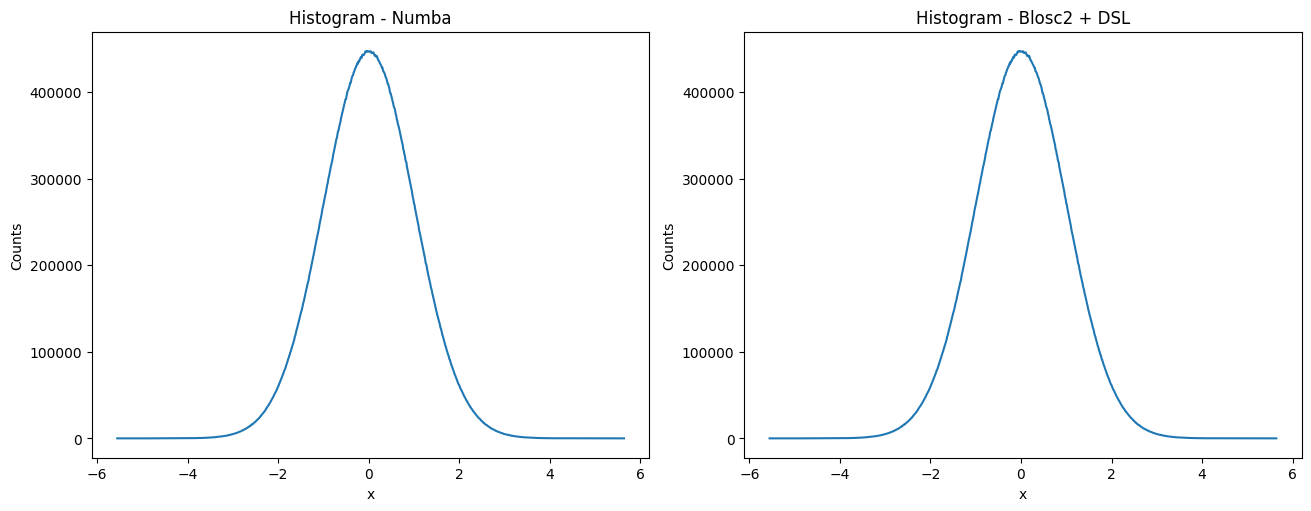

In [12]:
# Plot histogram
fig, ax = plt.subplots(1, 2, figsize=(13, 5), constrained_layout=True)

width = res_numba_native[1][1] - res_numba_native[1][0]
im0 = ax[0].plot(
    res_numba_native[1][:-1] + width,
    res_numba_native[0],
)
ax[0].set_title("Histogram - Numba")
ax[0].set_xlabel("x")
ax[0].set_ylabel("Counts")

im0 = ax[1].plot(
    res_dsl_cc[1][:-1] + width,
    res_dsl_cc[0],
)
ax[1].set_title("Histogram - Blosc2 + DSL")
ax[1].set_xlabel("x")
ax[1].set_ylabel("Counts")

plt.show()